# Load data 

首先请你学习plot_waterfall_with_subplot函数，熟悉瀑布图绘制的基本逻辑

其次请你学习analyze_policy_paths_by_pixel_with_ci函数，熟悉各个价格的基本逻辑

现在我需要按照不同政策类别绘制不同的瀑布图（不要P4、一共9个子图，每个图30mm的width，按照3×3排列）+Overall（含有P4）的图

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

# Load data
df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_pv_npv = pd.read_csv(r'data\US_data\df_pv_npv.csv')
df_agricultural_npv=pd.read_csv(r'data\US_data\df_agricultural_npv.csv')
df_afforestation_npv=pd.read_csv(r'data\US_data\df_afforestation_npv.csv')
df_natural_npv=pd.read_csv(r'data\US_data\df_natural_npv.csv')
# df_climate_zone=pd.read_csv(r'data\US_data\df_zones.csv')
df_weight=pd.read_csv(r'data\US_data\df_weight.csv')

# 定义政策类别（不包括P4）
policy_categories = ['P1a', 'P1b', 'P1c', 'P1d', 'P2a', 'P2c', 'P2', 'P3a', 'P3b', 'P3c']

print(f"Policy categories: {policy_categories}")
print(f"Total categories: {len(policy_categories)}")


Policy categories: ['P1a', 'P1b', 'P1c', 'P1d', 'P2a', 'P2c', 'P2', 'P3a', 'P3b', 'P3c']
Total categories: 10


第一，建议保持统一纵轴范围（目前已做到），但可以加上轻微灰色网格线（如 ax.grid(True, axis='y', linestyle='--', alpha=0.3)），增加层次感。
第二，面板标题重新设计，取消面板标题p1a-p3c，每个图片取消上边框与右边框    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
第三，为3×3的图片创建网格，让各个subplot在各个网格中居中

In [19]:
def calculate_waterfall_data_by_policy_categories(
    df_pv_npv, df_agricultural_npv, df_afforestation_npv, 
    df_natural_npv, df_economic, df_weight, policy_categories, target_year=2050):
    """
    计算指定政策类别的瀑布图数据
    
    Parameters
    ----------
    df_pv_npv : DataFrame
        光伏NPV数据
    df_agricultural_npv : DataFrame
        农业NPV数据
    df_afforestation_npv : DataFrame
        造林NPV数据
    df_natural_npv : DataFrame
        自然恢复NPV数据
    df_economic : DataFrame
        经济可行性数据
    df_weight : DataFrame
        权重数据
    policy_categories : list
        政策类别列表，如 ['P1a', 'P1b', 'P1c', 'P1d', 'P2a', 'P2c', 'P2', 'P3a', 'P3b', 'P3c']
    target_year : int
        目标年份，默认2050
        
    Returns
    -------
    df_benefit : DataFrame
        包含所有政策类别的瀑布图数据
    df_opportunity : DataFrame
        各RCP类别下的机会成本期望值
    """
    import pandas as pd
    import numpy as np
    
    # 列名小写
    for df in [df_pv_npv, df_agricultural_npv, df_afforestation_npv, df_natural_npv, df_economic, df_weight]:
        df.columns = df.columns.str.lower()
    
    # 筛选目标年份数据
    pv_data = df_pv_npv[df_pv_npv['analysis_year'] == target_year].copy()
    agri_data = df_agricultural_npv[df_agricultural_npv['analysis_year'] == target_year].copy()
    aff_data = df_afforestation_npv[df_afforestation_npv['analysis_year'] == target_year].copy()
    natural_data = df_natural_npv[df_natural_npv['analysis_year'] == target_year].copy()
    economic_data = df_economic[df_economic['analysis_year'] == target_year].copy()
    
    # 合并权重数据
    def merge_with_weight(df, weight_cols):
        return df.merge(df_weight[['lat', 'lon'] + weight_cols], on=['lat', 'lon'], how='left')
    
    agri_weighted = merge_with_weight(agri_data, ['weighted_density_agricultural'])
    aff_weighted = merge_with_weight(aff_data, ['weighted_density_forest'])
    natural_weighted = merge_with_weight(natural_data, ['weighted_density_vegetation'])
    
    # ========== 新增：计算 df_opportunity ==========
    # 识别 RCP 列名（可能在 rcp_category, RCP_Category 等）
    def find_rcp_column(df):
        for col in df.columns:
            if 'rcp' in col.lower() and 'category' in col.lower():
                return col
        return None
    
    rcp_col_agri = find_rcp_column(agri_data)
    rcp_col_aff = find_rcp_column(aff_data)
    rcp_col_natural = find_rcp_column(natural_data)
    
    # 准备机会成本数据
    opportunity_results = []
    
    if rcp_col_agri and rcp_col_aff and rcp_col_natural:
        # 获取所有唯一的 RCP 类别
        all_rcps = sorted(set(agri_weighted[rcp_col_agri].dropna().unique()) | 
                          set(aff_weighted[rcp_col_aff].dropna().unique()) | 
                          set(natural_weighted[rcp_col_natural].dropna().unique()))
        
        print(f"\n发现 RCP 类别: {all_rcps}")
        
        # 为每个 RCP 类别计算期望值
        for rcp in all_rcps:
            # 筛选该 RCP 的数据
            agri_rcp = agri_weighted[agri_weighted[rcp_col_agri] == rcp].copy()
            aff_rcp = aff_weighted[aff_weighted[rcp_col_aff] == rcp].copy()
            natural_rcp = natural_weighted[natural_weighted[rcp_col_natural] == rcp].copy()
            
            if not agri_rcp.empty and not aff_rcp.empty and not natural_rcp.empty:
                # 像素级别计算
                agri_pixel_rcp = agri_rcp.groupby(['lat', 'lon'], as_index=False)[['cumulative_npv_usd', 'weighted_density_agricultural']].mean()
                aff_pixel_rcp = aff_rcp.groupby(['lat', 'lon'], as_index=False)[['cumulative_npv_usd', 'weighted_density_forest']].mean()
                natural_pixel_rcp = natural_rcp.groupby(['lat', 'lon'], as_index=False)[['cumulative_npv_usd', 'weighted_density_vegetation']].mean()
                
                # 合并数据
                merged_rcp = agri_pixel_rcp.merge(aff_pixel_rcp, on=['lat', 'lon'], how='inner', suffixes=('', '_aff'))
                merged_rcp = merged_rcp.merge(natural_pixel_rcp, on=['lat', 'lon'], how='inner', suffixes=('', '_natural'))
                
                # 计算各组成部分的期望值
                agricultural_expected = (merged_rcp['weighted_density_agricultural'] * merged_rcp['cumulative_npv_usd']).mean()
                forest_expected = (merged_rcp['weighted_density_forest'] * merged_rcp['cumulative_npv_usd_aff']).mean()
                vegetation_expected = (merged_rcp['weighted_density_vegetation'] * merged_rcp['cumulative_npv_usd_natural']).mean()
                
                opportunity_results.append({
                    'RCP_Category': rcp,
                    'Agricultural_Expected': agricultural_expected,
                    'Forest_Expected': forest_expected,
                    'Vegetation_Expected': vegetation_expected,
                    'Total_Expected': agricultural_expected + forest_expected + vegetation_expected
                })
    
    df_opportunity = pd.DataFrame(opportunity_results)
    
    # 存储所有结果
    results = []
    
    # 为每个政策类别计算
    for policy in policy_categories:
        # 筛选该政策的数据
        pv_subset = pv_data[pv_data['policy_category'] == policy].copy()
        economic_subset = economic_data[economic_data['policy_category'] == policy].copy()
        
        # 1. Revenue (收入) - cumulative_npv_usd + cumulative_cost_usd
        if not pv_subset.empty:
            pv_grouped = pv_subset.groupby(['lat', 'lon'], as_index=False)[['cumulative_npv_usd', 'cumulative_cost_usd']].mean()
            revenue_mean = (pv_grouped['cumulative_npv_usd'] + pv_grouped['cumulative_cost_usd']).mean()
        else:
            revenue_mean = 0
        
        # 2. Expenditure (支出) - cumulative_cost_usd
        if not pv_subset.empty:
            pv_grouped = pv_subset.groupby(['lat', 'lon'], as_index=False)['cumulative_cost_usd'].mean()
            expenditure_mean = pv_grouped['cumulative_cost_usd'].mean()
        else:
            expenditure_mean = 0
        
        # 3. Opportunity (机会成本) - 使用所有像素的平均值
        agri_pixel = agri_weighted.groupby(['lat', 'lon'], as_index=False)[['cumulative_npv_usd', 'weighted_density_agricultural']].mean()
        aff_pixel = aff_weighted.groupby(['lat', 'lon'], as_index=False)[['cumulative_npv_usd', 'weighted_density_forest']].mean()
        natural_pixel = natural_weighted.groupby(['lat', 'lon'], as_index=False)[['cumulative_npv_usd', 'weighted_density_vegetation']].mean()
        
        # 合并数据
        merged = agri_pixel.merge(aff_pixel, on=['lat', 'lon'], how='inner', suffixes=('', '_aff'))
        merged = merged.merge(natural_pixel, on=['lat', 'lon'], how='inner', suffixes=('', '_natural'))
        
        # 计算像素级别的机会成本
        merged['pixel_opportunity_cost'] = (
            merged['weighted_density_forest'] * merged['cumulative_npv_usd_aff'] +
            merged['weighted_density_agricultural'] * merged['cumulative_npv_usd'] +
            merged['weighted_density_vegetation'] * merged['cumulative_npv_usd_natural']
        )
        
        opportunity_mean = merged['pixel_opportunity_cost'].mean()
        
        # 4. Net (净收益) - net_npv_usd
        if not economic_subset.empty:
            economic_grouped = economic_subset.groupby(['lat', 'lon'], as_index=False)['net_npv_usd'].mean()
            net_mean = economic_grouped['net_npv_usd'].mean()
        else:
            net_mean = 0
        
        # 记录结果
        results.append({
            'policy_category': policy,
            'Revenue_Mean': revenue_mean,
            'Expenditure_Mean': expenditure_mean,
            'Opportunity_Mean': opportunity_mean,
            'Net_Mean': net_mean
        })
    
    # 计算 Overall (包含所有P1, P2, P3政策，P4也包含)
    pv_overall = pv_data.copy()
    economic_overall = economic_data.copy()
    
    # Revenue Overall
    if not pv_overall.empty:
        pv_overall_grouped = pv_overall.groupby(['lat', 'lon'], as_index=False)[['cumulative_npv_usd', 'cumulative_cost_usd']].mean()
        revenue_overall = (pv_overall_grouped['cumulative_npv_usd'] + pv_overall_grouped['cumulative_cost_usd']).mean()
    else:
        revenue_overall = 0
    
    # Expenditure Overall
    if not pv_overall.empty:
        pv_overall_grouped = pv_overall.groupby(['lat', 'lon'], as_index=False)['cumulative_cost_usd'].mean()
        expenditure_overall = pv_overall_grouped['cumulative_cost_usd'].mean()
    else:
        expenditure_overall = 0
    
    # Opportunity Overall (使用所有像素)
    opportunity_overall = merged['pixel_opportunity_cost'].mean()
    
    # Net Overall
    if not economic_overall.empty:
        economic_overall_grouped = economic_overall.groupby(['lat', 'lon'], as_index=False)['net_npv_usd'].mean()
        net_overall = economic_overall_grouped['net_npv_usd'].mean()
    else:
        net_overall = 0
    
    # 添加 Overall
    results.append({
        'policy_category': 'Overall',
        'Revenue_Mean': revenue_overall,
        'Expenditure_Mean': expenditure_overall,
        'Opportunity_Mean': opportunity_overall,
        'Net_Mean': net_overall
    })
    
    # 转换为 DataFrame
    df_benefit = pd.DataFrame(results)
    
    return df_benefit, df_opportunity


# 使用示例
policy_categories = ['P1a', 'P1b', 'P1c', 'P1d', 'P2a', 'P2c', 'P2', 'P3a', 'P3b', 'P3c']

df_benefit_for_waterfall, df_opportunity = calculate_waterfall_data_by_policy_categories(
    df_pv_npv, df_agricultural_npv, df_afforestation_npv, 
    df_natural_npv, df_economic, df_weight, 
    policy_categories, target_year=2050
)



发现 RCP 类别: ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']


In [20]:
df_benefit_for_waterfall.replace({'policy_category': {'P2': 'P2b'}}, inplace=True)
df_benefit_for_waterfall

,policy_category,Revenue_Mean,Expenditure_Mean,Opportunity_Mean,Net_Mean
0,P1a,2.754030e+06,5.444369e+06,-799.336632,-2.689539e+06
1,P1b,3.291713e+06,5.497964e+06,-799.336632,-2.205451e+06
2,P1c,4.989486e+06,5.243445e+06,-799.336632,-2.531592e+05
3,P1d,2.637316e+06,4.171956e+06,-799.336632,-1.533840e+06
4,P2a,5.343923e+06,5.543635e+06,-799.336632,-1.989135e+05
5,P2c,3.732909e+06,5.866036e+06,-799.336632,-2.132328e+06
6,P2b,3.321407e+06,4.225846e+06,-799.336632,-9.036400e+05
7,P3a,3.611629e+06,5.381052e+06,-799.336632,-1.768623e+06
8,P3b,7.229343e+06,5.188424e+06,-799.336632,2.041719e+06
9,P3c,3.137213e+06,2.959927e+06,-799.336632,1.780860e+05


# 2、Plot Waterfall


布局信息:
  图形尺寸: 95.0mm x 80.0mm
  每个子图: 24.33mm x 20.33mm
  水平间距: 2.00mm
  垂直间距: 1.00mm
  列头高度: 6.0mm
  行头宽度: 8.0mm
  极窄轴宽度: 0.095mm


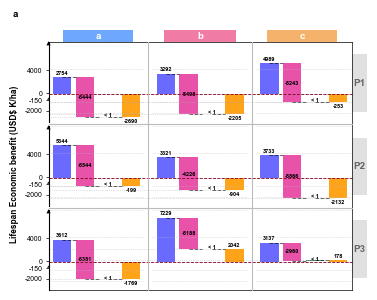

In [142]:
def add_y_break_marks(ax, y_frac, *, width=0.008, half_len=0.01, gap=0.010, lw=0.5, color='k'):
    """在 y=y_frac 处画左侧断轴符号"""
    tr = ax.transAxes
    x0, x1 = 0.0 - width, 0.0 + width
    ax.plot([x0, x1], [y_frac - half_len, y_frac + half_len], transform=tr,
            color=color, lw=lw, clip_on=False, zorder=20)
    ax.plot([x0, x1], [y_frac - half_len - gap, y_frac + half_len - gap], transform=tr,
            color=color, lw=lw, clip_on=False, zorder=20)

def draw_bar_between(ax, x, v0, v1, color, width, y_transform, breaks=(-150.0, 0.0), alpha=0.9):
    """在 v0→v1 之间按分段轴映射画段柱"""
    if v0 == v1:
        return
    pts = [v0] + [b for b in breaks if (v0 < b < v1) or (v1 < b < v0)] + [v1]
    pts.sort()
    for a, b in zip(pts[:-1], pts[1:]):
        yb, yt = y_transform(min(a, b)), y_transform(max(a, b))
        h = abs(yt - yb)
        if h > 0:
            ax.bar(x, h, width=width, bottom=min(yb, yt),
                   color=color, alpha=alpha, edgecolor='none', linewidth=0)

def draw_from_zero(ax, x, value_k, width, color, y_transform):
    draw_bar_between(ax, x, 0.0, value_k, color, width, y_transform)

def draw_from_end(ax, x, before_k, after_k, width, color, y_transform):
    draw_bar_between(ax, x, before_k, after_k, color, width, y_transform)

def draw_from_end_linear_signed(ax, x, before_k, after_k, width, ytr, color, alpha=0.95):
    """纯线性轴：以 before→after 画带符号高度的段柱"""
    yb, ya = ytr(before_k), ytr(after_k)
    h = ya - yb
    if abs(h) < 1e-12:
        return
    ax.bar(x, h, width=width, bottom=yb, color=color, alpha=alpha, edgecolor='none')

def build_linear_transform(vmin, vmax):
    span = max(vmax - vmin, 1e-9)
    return lambda v: (v - vmin) / span



def build_segmented_axis(y_stretch_neg_max=-150.0, y_stretch_pos_max=0.0,
                         neg_stretch_ratio=0.10, pos_stretch_ratio=0.0, normal_ratio=0.90,
                         y_min=-3500.0, y_max=8500.0):
    """
    构建分段Y轴（统一范围：负轴-3500到0，正轴0到8500）
    
    Parameters
    ----------
    y_stretch_neg_max : float
        负向拉伸区域的结束值，默认-150.0
    y_stretch_pos_max : float
        正向拉伸区域的结束值，默认0.0
    neg_stretch_ratio : float
        负向拉伸区域占轴的比例，默认0.10
    pos_stretch_ratio : float
        正向拉伸区域占轴的比例，默认0.0
    normal_ratio : float
        正常比例区域占轴的比例，默认0.90
    y_min : float
        固定Y轴最小值，默认-3500.0
    y_max : float
        固定Y轴最大值，默认8500.0
    
    Returns
    -------
    y_transform : function
        Y轴转换函数，将数据值转换为0-1范围
    ticks : list
        刻度值列表
    info : dict
        分段轴信息字典
    """
    # ---- 分段长度 ----
    lo_span         = max(y_stretch_neg_max - y_min, 1e-9)   # [-3500, -150]
    neg_stretch_span= max(0.0 - y_stretch_neg_max, 1e-9)     # [-150, 0]
    pos_stretch_span= max(y_stretch_pos_max - 0.0, 1e-9)     # [0, 0] 这里为 0
    hi_span         = max(y_max - y_stretch_pos_max, 1e-9)   # [0, 8500]

    total_normal_span = lo_span + hi_span
    lower_norm_ratio  = (normal_ratio * (lo_span / total_normal_span)
                         if total_normal_span > 1e-9 else normal_ratio * 0.5)
    upper_norm_ratio  = normal_ratio - lower_norm_ratio

    B0 = 0.0
    B1 = B0 + lower_norm_ratio
    B2 = B1 + neg_stretch_ratio
    B3 = B2 + pos_stretch_ratio  # 这里等于 B2
    B4 = 1.0

    def y_transform(v):
        if v <= y_stretch_neg_max:
            return B0 + (v - y_min) / lo_span * (B1 - B0)
        elif v <= 0.0:
            return B1 + (v - y_stretch_neg_max) / neg_stretch_span * (B2 - B1)
        else:
            return B3 + (v - y_stretch_pos_max) / hi_span * (B4 - B3)

    # 只保留真实需要的刻度（与图面一致）
    ticks = [-3500.0, -2000.0, y_stretch_neg_max, 0.0, 4000.0, 8500.0]
    info = dict(y_min=y_min, y_max=y_max, y_stretch_neg_max=y_stretch_neg_max,
                y_stretch_pos_max=y_stretch_pos_max, B=(B0, B1, B2, B3, B4))
    return y_transform, ticks, info


def draw_guides_in_axes(ax, ytr, values, *, ls=':', lw=0.5, color='0.75', zorder=1):
    """
    在每个子图内，用 ytr() 把关键参考值画成真正的水平线
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        子图轴
    ytr : function
        Y轴转换函数
    values : list
        要绘制参考线的数值列表
    ls : str
        线型，默认':'
    lw : float
        线宽，默认0.5
    color : str
        颜色，默认'0.75'（浅灰）
    zorder : int
        图层顺序，默认1（在柱体之下）
    """
    ys = [ytr(v) for v in values]
    for y in ys:
        ax.axhline(y, ls=ls, lw=lw, color=color, zorder=zorder)

def add_row_segment_yaxes(
    fig, axes_mat, *, ytr, yticks,
    width_frac=0.001,          # 极窄轴宽
    pad=0.10,                  # 行内可见区上下"内容留白"（之前的视觉留白，保持不变）
    cap=0.04,                  # 软扩展比例：轴显示范围 [-cap, 1+cap]
    color='black', spine_lw=0.2, tick_lw=0.6, tick_len=2.5, labelsize=5,
    hatch_color='0.82', hatch_lw=0.6,
    draw_row_zero_line=True, zero_ls='--', zero_lw=0.6, zero_color='lightgray',
    y_top=None, y_mid1=None, y_mid2=None, y_bottom=None,
    net_positions=None
):
    """
    仅在左侧三段窄轴上做"软扩展+端部隐藏"，表现压缩感。
    - 窄轴用统一 ticks；只过滤出现在 (pad,1-pad) 可视带中的刻度
    """
    from matplotlib.patches import Rectangle, FancyArrowPatch
    from matplotlib.lines import Line2D
    import matplotlib.patches as mpatches
    
    for i in range(3):
        pos = axes_mat[i, 0].get_position()
        x0, y0, h = pos.x0, pos.y0, pos.height
        axn = fig.add_axes([x0, y0, width_frac, h])
        
        # 注意：窄轴做软扩；子图不做
        axn.set_ylim(-cap, 1+cap)
        axn.set_xlim(0, 1)
        axn.set_xticks([])
        
        # 窄轴用统一 ticks；只过滤出现在 (pad,1-pad) 可视带中的刻度
        kept_vals = []
        for v in yticks:
            f = ytr(v)
            if pad < f < 1 - pad:
                kept_vals.append(v)
        
        axn.set_yticks([ytr(v) for v in kept_vals])
        axn.set_yticklabels([f'{v:.0f}' for v in kept_vals], fontsize=labelsize, color=color)
        axn.tick_params(axis='y', direction='out', length=tick_len, width=tick_lw, colors=color, pad=2)
        
        # 只开左脊线
        for k in ('top', 'right', 'bottom'):
            axn.spines[k].set_visible(False)
        axn.spines['left'].set_visible(True)
        axn.spines['left'].set_linewidth(spine_lw)
        axn.spines['left'].set_color(color)
        
        # —— 行内"内容留白"区 (pad) 不变：只在窄轴上可视化 —— #
        # 画 pad 边界虚线（在 0..1 的内部）
        axn.axhline(1-pad, color=hatch_color, linestyle='--', linewidth=hatch_lw, zorder=6)
        axn.axhline(pad,    color=hatch_color, linestyle='--', linewidth=hatch_lw, zorder=6)
        
        # —— 在Y轴顶端和底端添加实心箭头（使用更小的箭头） —— #
        from matplotlib.patches import FancyArrowPatch
        
        # 箭头参数
        arrow_offset = 0.005  # 箭头长度（在data坐标系中）
        arrow_scale = 6  # 箭头大小（可以调小，比如4或5会更小）
        
        # 顶端箭头（向上，略微上移）
        arrow_top = FancyArrowPatch(
            posA=(0, 1+cap-arrow_offset+0.01),  # 起点整体上移0.01
            posB=(0, 1+cap+0.01),               # 终点整体上移0.01
            transform=axn.get_yaxis_transform(),  # 使用Y轴transform（x在axes坐标，y在data坐标）
            arrowstyle='simple',
            color=color, 
            linewidth=0,  # 只显示箭头，不显示线
            mutation_scale=arrow_scale, 
            zorder=10,
            clip_on=False
        )
        axn.add_patch(arrow_top)
        
        # —— 行级 0 线（figure 层，保证与子图/窄轴严格对齐） —— #
        if draw_row_zero_line:
            y0_fig = y0 + h * ytr(0.0)              
            x_left  = axes_mat[i, 0].get_position().x0
            x_right = axes_mat[i, 2].get_position().x1
            # 酒红色: '#800020'，zorder设置为1（在柱体之下）
            fig.add_artist(Line2D([x_left, x_right], [y0_fig, y0_fig],
                           transform=fig.transFigure, color='#800020', lw=zero_lw, ls=zero_ls, zorder=1))
    
    # 在figure层面绘制各个子图的net终点柱体到Y轴的连线（灰色虚线）
    if net_positions is not None and len(net_positions) > 0 and axes_mat[0, 0] is not None:
        x_yaxis = axes_mat[0, 0].get_position().x0  # Y轴位置（最左侧）
        for (i, j), net_info in net_positions.items():
            ax_subplot = net_info['ax']
            # 获取子图在figure中的位置
            pos = ax_subplot.get_position()
            # 计算net终点在figure坐标系中的位置
            # x_net_center_axes是相对于axes的坐标（0-1之间），需要转换为figure坐标
            x_net_fig = pos.x0 + net_info['x_net_center_axes'] * pos.width
            y_net_fig = pos.y0 + net_info['y_net_end_axes'] * pos.height
            
            # 从net终点到Y轴画线（灰色虚线，zorder在柱体之下但在0线之上）
            fig.add_artist(Line2D([x_net_fig, x_yaxis], [y_net_fig, y_net_fig],
                           transform=fig.transFigure, color='gray', lw=0.5, ls=':', alpha=0.5, zorder=1.5))




def plot_single_policy_waterfall(row_data, df_opportunity, policy_name, ax, ytr, yticks, axinfo, magnify_opp=15, show_break_marks=False):
    """
    为单个政策绘制瀑布图（简化版）
    
    Parameters
    ----------
    row_data : Series
        包含 Revenue_Mean, Expenditure_Mean, Opportunity_Mean, Net_Mean
    df_opportunity : DataFrame
        各RCP类别的机会成本期望值
    policy_name : str
        政策名称（不再显示，仅用于识别）
    ax : matplotlib.axes.Axes
        绘图轴
    ytr : function
        全局统一的Y轴转换函数
    yticks : list
        全局统一的Y轴刻度列表
    axinfo : dict
        分段轴信息字典
    magnify_opp : float
        机会成本放大系数，默认15
    """
    K = 1000.0
    
    # 提取数据
    rev = row_data['Revenue_Mean'] / K
    exp = row_data['Expenditure_Mean'] / K
    opp = row_data['Opportunity_Mean'] / K
    net = row_data['Net_Mean'] / K
    
    after_exp = rev - exp
    
    # 从 df_opportunity 获取机会成本组成部分
    if not df_opportunity.empty:
        # 计算所有RCP的平均值
        ag_k = df_opportunity['Agricultural_Expected'].mean() / K
        fo_k = df_opportunity['Forest_Expected'].mean() / K
        ve_k = df_opportunity['Vegetation_Expected'].mean() / K
    else:
        # 如果没有机会成本数据，使用简单分解
        ag_k = fo_k = ve_k = abs(opp) / 3
    
    y0 = ytr(0.0)
    
    ax.set_ylim(0, 1)
    # 移除y刻度（因为会在极窄轴上显示）
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=5, length=2, width=0.5)
    
    # 在-150处绘制断轴标记
    if show_break_marks:
        y_break = ytr(axinfo['y_stretch_neg_max'])
        add_y_break_marks(ax, y_break + 0.04)
    # 柱子位置
    x = 0.5  # 中心位置
    step, base_w = 0.20, 0.16
    col_rev, col_exp, col_net = '#5A5AFE', '#E63FA0', '#FF9900'
    col_opp = ['#DAA520', '#2E8B57', '#4682B4']
    
    # ---- Revenue ----
    x_rev = x - 1.5*step
    draw_from_zero(ax, x_rev, rev, base_w, col_rev, ytr)
    ax.text(x_rev, ytr(rev) + 0.02, f'{rev:.0f}',
            ha='center', va='bottom', fontsize=4, fontweight='bold')
    
    # ---- Expenditure ----
    x_exp = x - 0.5*step
    draw_from_end(ax, x_exp, rev, after_exp, base_w, col_exp, ytr)
    exp_height = ytr(rev) - ytr(after_exp)
    ax.text(x_exp, ytr(after_exp) + exp_height/2, f'{-exp:.0f}',
            ha='center', va='center', fontsize=4, fontweight='bold')
    
    # ---- Opportunity ----
    x_opp = x + 0.5*step
    parts = [-ag_k*magnify_opp, -fo_k*magnify_opp, -ve_k*magnify_opp]
    
    # 计算三段高度
    y_bottom_axes = ytr(after_exp)
    seg_h_raw = []
    cur_data = after_exp
    for p in parts:
        nxt_data = cur_data + p
        seg_h_raw.append(abs(ytr(nxt_data) - ytr(cur_data)))
        cur_data = nxt_data
    raw_total_h = sum(seg_h_raw)
    
    # 绘制堆叠柱子
    cum = 0.0
    for h_raw, c in zip(seg_h_raw, col_opp):
        h_scaled = h_raw
        bottom_axes = y_bottom_axes + cum
        ax.bar(x_opp, h_scaled, width=base_w, bottom=bottom_axes,
               color=c, alpha=0.9, edgecolor='none', linewidth=0)
        cum += h_scaled
    
    # 机会成本标签
    total_opp = -(ag_k + fo_k + ve_k)
    label_txt = '< 1' if abs(total_opp) < 1 else f'{total_opp:.0f}'
    opp_end_axes = y_bottom_axes + raw_total_h
    ax.text(x_opp, (y_bottom_axes + opp_end_axes)/2 + 0.02, label_txt,
            ha='center', va='center', fontsize=4, fontweight='bold')
    
    # ---- Net ----
    x_net = x + 1.5*step
    net_end_axes = opp_end_axes
    net_start_axes = ytr(0.0)
    net_height_axes = abs(net_end_axes - net_start_axes)
    net_bottom_axes = min(net_start_axes, net_end_axes)
    ax.bar(x_net, net_height_axes, width=base_w, bottom=net_bottom_axes,
           color=col_net, alpha=0.9, edgecolor='none', linewidth=0)
    
    ax.text(x_net, net_end_axes + (0.02 if net >= 0 else -0.02), f'{net:.0f}',
            ha='center', va='bottom' if net >= 0 else 'top',
            fontsize=4, fontweight='bold')
    
    # 组内连线：从各个bar的中点（水平方向）到下一个bar的左侧起点
    # Revenue顶部中点 → Expenditure顶部左侧起点
    ax.plot([x_rev, x_exp - base_w/2], [ytr(rev), ytr(rev)],
            color='black', linestyle='--', lw=0.7, alpha=0.6, zorder=15)
    
    # Expenditure底部中点 → Opportunity顶部左侧起点
    ax.plot([x_exp, x_opp - base_w/2], [ytr(after_exp), ytr(after_exp)],
            color='black', linestyle='--', lw=0.7, alpha=0.6, zorder=15)
    
    # Opportunity底部中点 → Net对应位置左侧起点
    ax.plot([x_opp, x_net - base_w/2], [opp_end_axes, opp_end_axes],
            color='black', linestyle='--', lw=0.7, alpha=0.6, zorder=15)
    
    # 移除x轴刻度
    ax.set_xticks([])
    ax.tick_params(axis='both', labelsize=5, length=2, width=0.5)
    
    # 改进2: 边框样式调整 - 去掉左、下框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)   # 去掉左框线
    ax.spines['bottom'].set_visible(False)  # 去掉下框线
    
    guide_values = [-3500.0, -2000.0, axinfo['y_stretch_neg_max'], 0.0, 4000.0, 8500.0]
    draw_guides_in_axes(ax, ytr, guide_values, ls=':', lw=0.4, color='0.75', zorder=1)
    # 改进1: 添加轻微灰色网格线（改为浅灰参考线）
    ax.grid(True, axis='y', linestyle='--', linewidth=0.4, alpha=0.3, color='lightgray')
    return {
    'x_net': x_net,
    'y_net_end': net_end_axes,
    'x_net_center_axes': x_net,  # 在axes坐标系中的x位置（0-1之间）
    'y_net_end_axes': net_end_axes  # 在axes坐标系中的y位置（0-1之间）
    }




def plot_multi_policy_waterfall(df_benefit, df_opportunity, policy_categories=None, 
                                 magnify_opp=15, fig_width_mm=90.0, fig_height_mm=90.0,
                                 subplot_width_mm=None, subplot_height_mm=None,
                                 wspace_mm=None, hspace_mm=None,
                                 left_mm=None, bottom_mm=None, right_mm=None, top_mm=None,
                                 wspace=0.3, hspace=0.3,
                                 left=0.08, bottom=0.08, right=0.95, top=0.95,
                                 col_labels=('a', 'b', 'c'),
                                 row_labels=('P1', 'P2', 'P3'),
                                 col_colors=('#6ea8fe', '#f07ba5', '#f5b26b'),
                                 row_color='#f0f0f0',
                                 header_h_mm=6,
                                 rowlab_w_mm=8,
                                 spine_lw=0.5,
                                 grid_lw=0.8):
    """
    绘制多个政策类别的瀑布图矩阵（带行列头）
    
    Parameters
    ----------
    ... (保持原有参数说明)
        
    Returns
    -------
    fig : matplotlib.figure.Figure
    axes : ndarray
        子图数组（3×3）
    """
    from matplotlib.patches import Rectangle
    from matplotlib.lines import Line2D
    from matplotlib import gridspec
    
    plt.rcParams['font.family'] = 'Arial'
    
    # 全局一次性构建分段轴映射（不要在subplot内重复构建）
    YTR, YTICKS, AXINFO = build_segmented_axis(
        y_min=-3500.0, y_max=8500.0,
        neg_stretch_ratio=0.10, normal_ratio=0.90
    )
    
    # 确定政策类别
    if policy_categories is None:
        policy_categories = df_benefit[df_benefit['policy_category'] != 'Overall']['policy_category'].tolist()
    
    # 添加Overall到列表末尾
    all_policies = policy_categories + ['Overall']
    
    # 转换figure大小为英寸
    fig_width_inches = fig_width_mm / 25.4
    fig_height_inches = fig_height_mm / 25.4
    
    # 创建figure
    fig = plt.figure(figsize=(fig_width_inches, fig_height_inches))
    
    # 使用GridSpec进行精确控制
    # 首先确定边距（毫米转相对值）
    if left_mm is not None:
        left0 = left_mm / fig_width_mm
    else:
        left0 = left
    
    if bottom_mm is not None:
        bot0 = bottom_mm / fig_height_mm
    else:
        bot0 = bottom
    
    if right_mm is not None:
        right0 = 1.0 - (right_mm / fig_width_mm)
    else:
        right0 = right
    
    if top_mm is not None:
        top0 = 1.0 - (top_mm / fig_height_mm)
    else:
        top0 = top
    
    # 计算各区块在figure坐标中的比例
    inner_w_mm = fig_width_mm * (right0 - left0)
    inner_h_mm = fig_height_mm * (top0 - bot0)
    
    # 行列头占用
    header_frac = header_h_mm / fig_height_mm
    rowlab_frac = rowlab_w_mm / fig_width_mm
    
    # 子图区域大小（含子图间距，但左边不留行头空间）
    avail_w_mm = inner_w_mm  # 不再减去rowlab_w_mm，因为行头在右侧
    avail_h_mm = inner_h_mm - header_h_mm
    
    # 确定子图尺寸和间距
    if subplot_width_mm is not None and subplot_height_mm is not None:
        # 指定了子图尺寸
        if wspace_mm is not None:
            total_width_needed = 3 * subplot_width_mm + 2 * wspace_mm
            if total_width_needed > avail_w_mm:
                scale = avail_w_mm / total_width_needed
                subplot_width_mm *= scale
                wspace_mm *= scale
                print(f"警告：水平方向超出，按比例缩放至 {subplot_width_mm:.2f}mm")
        else:
            total_subplot_width = 3 * subplot_width_mm
            remaining_width = avail_w_mm - total_subplot_width
            if remaining_width >= 0:
                wspace_mm = remaining_width / 2
            else:
                scale = avail_w_mm / (3 * subplot_width_mm * (1 + wspace))
                subplot_width_mm *= scale
                wspace_mm = subplot_width_mm * wspace
                print(f"警告：子图宽度超出，按比例缩放至 {subplot_width_mm:.2f}mm")
        
        if hspace_mm is not None:
            total_height_needed = 3 * subplot_height_mm + 2 * hspace_mm
            if total_height_needed > avail_h_mm:
                scale = avail_h_mm / total_height_needed
                subplot_height_mm *= scale
                hspace_mm *= scale
                print(f"警告：垂直方向超出，按比例缩放至 {subplot_height_mm:.2f}mm")
        else:
            total_subplot_height = 3 * subplot_height_mm
            remaining_height = avail_h_mm - total_subplot_height
            if remaining_height >= 0:
                hspace_mm = remaining_height / 2
            else:
                scale = avail_h_mm / (3 * subplot_height_mm * (1 + hspace))
                subplot_height_mm *= scale
                hspace_mm = subplot_height_mm * hspace
                print(f"警告：子图高度超出，按比例缩放至 {subplot_height_mm:.2f}mm")
    else:
        # 没有指定子图尺寸，使用相对值计算
        if wspace_mm is not None:
            subplot_width_mm = (avail_w_mm - 2 * wspace_mm) / 3
        else:
            subplot_width_mm = avail_w_mm / (3 + 2 * wspace)
            wspace_mm = subplot_width_mm * wspace
        
        if hspace_mm is not None:
            subplot_height_mm = (avail_h_mm - 2 * hspace_mm) / 3
        else:
            subplot_height_mm = avail_h_mm / (3 + 2 * hspace)
            hspace_mm = subplot_height_mm * hspace
    
    # 将毫米转换为figure坐标系中的相对值
    cell_w_frac = subplot_width_mm / fig_width_mm
    cell_h_frac = subplot_height_mm / fig_height_mm
    wspace_frac = wspace_mm / fig_width_mm
    hspace_frac = hspace_mm / fig_height_mm
    
    # 极窄轴宽度（几乎为0，用于显示刻度）
    narrow_axis_w_frac = 0.001  # 极窄，约0.1%
    
    net_positions = {}
    # 放置3×3子图（从极窄轴右侧开始）
    axes = np.empty((3, 3), dtype=object)
    
    for i in range(3):
        for j in range(3):
            idx = i * 3 + j
            if idx < len(all_policies):
                x0 = left0 + narrow_axis_w_frac + j * (cell_w_frac + wspace_frac)
                y0 = (top0 - header_frac) - i * (cell_h_frac + hspace_frac) - cell_h_frac
                ax = fig.add_axes([x0, y0, cell_w_frac, cell_h_frac])
                axes[i, j] = ax
                
                # 绘制瀑布图（传入全局统一的ytr, yticks, axinfo）
                policy = all_policies[idx]
                row_data = df_benefit[df_benefit['policy_category'] == policy].iloc[0]
                # 仅在最左侧列（j==0）显示断轴符号
                net_info = plot_single_policy_waterfall(row_data, df_opportunity, policy, ax, YTR, YTICKS, AXINFO, 
                                           magnify_opp, show_break_marks=(j == 0))
                # 存储net终点位置（在axes坐标系中）
                if net_info:
                    net_positions[(i, j)] = {
                        'x_net_center_axes': net_info['x_net_center_axes'],
                        'y_net_end_axes': net_info['y_net_end_axes'],
                        'ax': ax
                    }
            else:
                # 隐藏未使用的子图
                x0 = left0 + narrow_axis_w_frac + j * (cell_w_frac + wspace_frac)
                y0 = (top0 - header_frac) - i * (cell_h_frac + hspace_frac) - cell_h_frac
                ax = fig.add_axes([x0, y0, cell_w_frac, cell_h_frac])
                ax.axis('off')
                axes[i, j] = ax

    # 计算九宫格边界（用于列头定位）
    x_left = axes[0, 0].get_position().x0
    x_mid1 = axes[0, 0].get_position().x1 + wspace_frac / 2
    x_mid2 = axes[0, 1].get_position().x1 + wspace_frac / 2
    x_right = axes[0, 2].get_position().x1
    y_top = axes[0, 0].get_position().y1
    y_mid1 = axes[0, 0].get_position().y0 - hspace_frac / 2
    y_mid2 = axes[1, 0].get_position().y0 - hspace_frac / 2
    y_bottom = axes[2, 0].get_position().y0
    
    # 顶部列头 axes（根据九宫格边界调整）
    col_axes = []
    header_frac_compressed = header_frac / 2  # 高度压缩为1/2

    # a: 从x_left到x_mid1
    a_width = (x_mid1 - x_left) * 0.7
    a_left = x_left + (x_mid1 - x_left) * 0.15
    axh_a = fig.add_axes([a_left, top0 - 2*header_frac_compressed, a_width, header_frac_compressed])
    axh_a.add_patch(Rectangle((0, 0), 1, 1, transform=axh_a.transAxes,
                           facecolor=col_colors[0], edgecolor='none'))
    axh_a.text(0.5, 0.5, col_labels[0], ha='center', va='center',
            color='white', fontsize=7, fontweight='bold')
    axh_a.set_axis_off()
    col_axes.append(axh_a)
    
    # b: 从x_mid1到x_mid2
    b_width = (x_mid2 - x_mid1) * 0.7
    b_left = x_mid1 + (x_mid2 - x_mid1) * 0.15
    axh_b = fig.add_axes([b_left, top0 - 2*header_frac_compressed, b_width, header_frac_compressed])
    axh_b.add_patch(Rectangle((0, 0), 1, 1, transform=axh_b.transAxes,
                           facecolor=col_colors[1], edgecolor='none'))
    axh_b.text(0.5, 0.5, col_labels[1], ha='center', va='center',
            color='white', fontsize=7, fontweight='bold')
    axh_b.set_axis_off()
    col_axes.append(axh_b)
    
    # c: 从x_mid2到x_right
    c_width = (x_right - x_mid2) * 0.7
    c_left = x_mid2 + (x_right - x_mid2) * 0.15
    axh_c = fig.add_axes([c_left, top0 - 2*header_frac_compressed, c_width, header_frac_compressed])
    axh_c.add_patch(Rectangle((0, 0), 1, 1, transform=axh_c.transAxes,
                           facecolor=col_colors[2], edgecolor='none'))
    axh_c.text(0.5, 0.5, col_labels[2], ha='center', va='center',
            color='white', fontsize=7, fontweight='bold')
    axh_c.set_axis_off()
    col_axes.append(axh_c)
    
    # 左侧"分三段共享 y 轴"：使用 add_row_segment_yaxes
    add_row_segment_yaxes(fig, axes, ytr=YTR, yticks=YTICKS,
                                   width_frac=narrow_axis_w_frac,
                                   color='black', spine_lw=0.8, tick_lw=0.5, tick_len=2.5, labelsize=5,
                                   pad=0.10, cap=0.04, hatch_color='0.82', hatch_lw=0.6,
                                   draw_row_zero_line=True, zero_ls='--', zero_lw=0.6, zero_color='lightgray',
                                   y_top=y_top, y_mid1=y_mid1, y_mid2=y_mid2, y_bottom=y_bottom,
                                   net_positions=net_positions)  # 传递net_positions

    # 右侧行头 axes（根据九宫格边界调整）
    row_axes = []
    # 定义灰色配色
    gray_facecolor = '#e0e0e0'  # 浅灰
    gray_textcolor = '#666666'  # 深一点的灰

    # P1: 从y_mid1到y_top，长度减少20%
    p1_height = (y_top - y_mid1) * 0.7
    axr_p1 = fig.add_axes([x_right, y_mid1 + (y_top - y_mid1) * 0.15, rowlab_frac / 2, p1_height])
    axr_p1.add_patch(Rectangle((0, 0), 1, 1, transform=axr_p1.transAxes,
                               facecolor=gray_facecolor, edgecolor='none'))
    axr_p1.text(0.5, 0.5, row_labels[0], ha='center', va='center',
                color=gray_textcolor, fontsize=7, fontweight='bold')
    axr_p1.set_axis_off()
    row_axes.append(axr_p1)

    # P2: 从y_mid2到y_mid1
    axr_p2 = fig.add_axes([x_right, y_mid2 + (y_mid1 - y_mid2) * 0.15, rowlab_frac / 2, p1_height])
    axr_p2.add_patch(Rectangle((0, 0), 1, 1, transform=axr_p2.transAxes,
                               facecolor=gray_facecolor, edgecolor='none'))
    axr_p2.text(0.5, 0.5, row_labels[1], ha='center', va='center',
                color=gray_textcolor, fontsize=7, fontweight='bold')
    axr_p2.set_axis_off()
    row_axes.append(axr_p2)

    # P3: 从y_bottom到y_mid2
    axr_p3 = fig.add_axes([x_right, y_bottom + (y_mid2 - y_bottom) * 0.15, rowlab_frac / 2, p1_height])
    axr_p3.add_patch(Rectangle((0, 0), 1, 1, transform=axr_p3.transAxes,
                               facecolor=gray_facecolor, edgecolor='none'))
    axr_p3.text(0.5, 0.5, row_labels[2], ha='center', va='center',
                color=gray_textcolor, fontsize=7, fontweight='bold')
    axr_p3.set_axis_off()
    row_axes.append(axr_p3)
    

    # 外框（不画左外框，保留其余三边）
    # 上边
    fig.add_artist(Line2D([x_left, x_right], [y_top, y_top],
                   transform=fig.transFigure, lw=spine_lw, color='black'))
    # 右边
    fig.add_artist(Line2D([x_right, x_right], [y_bottom, y_top],
                   transform=fig.transFigure, lw=spine_lw, color='black'))
    # 下边
    fig.add_artist(Line2D([x_left, x_right], [y_bottom, y_bottom],
                   transform=fig.transFigure, lw=spine_lw, color='black'))
    
    # 竖向分隔线（不画在极窄轴区域），灰色
    for x in (x_mid1, x_mid2):
        fig.add_artist(Line2D([x, x], [y_bottom, y_top],
                       transform=fig.transFigure, lw=grid_lw, color='#bbbbbb'))
    
    # 横向分隔线，灰色
    for y in (y_mid1, y_mid2):
        fig.add_artist(Line2D([x_left, x_right], [y, y],
                       transform=fig.transFigure, lw=grid_lw, color='#bbbbbb'))
    
    # 添加共享的Y轴标签（放在极窄轴左边）
    fig.text(left0 - 0.09, 0.5, 'Lifespan Economic benefit (USD$ K/ha)', 
             ha='center', va='center', rotation='vertical', fontsize=6, fontweight='bold')
    fig.text(0.01, 0.99, "a", ha='left', va='top', fontsize=7, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)
    
    # 打印布局信息
    print(f"\n布局信息:")
    print(f"  图形尺寸: {fig_width_mm:.1f}mm x {fig_height_mm:.1f}mm")
    print(f"  每个子图: {subplot_width_mm:.2f}mm x {subplot_height_mm:.2f}mm")
    print(f"  水平间距: {wspace_mm:.2f}mm")
    print(f"  垂直间距: {hspace_mm:.2f}mm")
    print(f"  列头高度: {header_h_mm:.1f}mm")
    print(f"  行头宽度: {rowlab_w_mm:.1f}mm")
    print(f"  极窄轴宽度: {narrow_axis_w_frac * fig_width_mm:.3f}mm")
    
    return fig, axes



# 使用示例
fig, axes = plot_multi_policy_waterfall(
    df_benefit_for_waterfall, df_opportunity, 
    policy_categories=['P1a', 'P1b', 'P1c', 'P2a', 'P2b', 'P2c', 'P3a', 'P3b', 'P3c'],
    magnify_opp=15,
    fig_width_mm=95.0,
    fig_height_mm=80,
    wspace_mm=2,
    hspace_mm=1,
    left_mm=10,
    bottom_mm=8,
    right_mm=8,
    top_mm=3,
    col_labels=('a', 'b', 'c'),
    row_labels=('P1', 'P2', 'P3'),
    col_colors=('#6ea8fe', '#f07ba5', '#f5b26b'),
    row_color='#f0f0f0',
    header_h_mm=6,
    rowlab_w_mm=8,
    spine_lw=0.5,
    grid_lw=0.8
)

fig.savefig('figure/US_figure/waterfall_matrix_auto.png', dpi=300)
fig.savefig('figure/US_figure/waterfall_matrix_auto.pdf', dpi=300)
plt.show()

In [ ]:
# # =========== 使用示例：同时控制总图大小、子图大小和间距 ===========

# # 示例1: 固定总图90mm，指定子图25mm，间距5mm
# fig1, axes1 = plot_multi_policy_waterfall(
#     df_benefit_for_waterfall, df_opportunity, 
#     policy_categories=['P1a', 'P1b', 'P1c', 'P2a', 'P2b', 'P2c', 'P3a', 'P3b', 'P3c'],
#     magnify_opp=15,
#     fig_width_mm=90.0,        # 固定总图宽度90mm
#     fig_height_mm=90.0,       # 固定总图高度90mm
#     subplot_width_mm=25.0,   # 每个子图宽度25mm
#     subplot_height_mm=25.0,  # 每个子图高度25mm
#     wspace_mm=5.0,            # 水平间距5mm
#     hspace_mm=5.0,           # 垂直间距5mm
#     left_mm=10.0,             # 左边距10mm
#     bottom_mm=8.0,            # 底边距8mm
#     right_mm=5.0,             # 右边距5mm
#     top_mm=5.0                # 顶边距5mm
# )

# fig1.savefig('figure/US_figure/waterfall_matrix_precise.png', dpi=300)
# fig1.savefig('figure/US_figure/waterfall_matrix_precise.pdf', dpi=300)
# plt.show()

# # 示例2: 固定总图，使用相对间距
# fig2, axes2 = plot_multi_policy_waterfall(
#     df_benefit_for_waterfall, df_opportunity, 
#     policy_categories=['P1a', 'P1b', 'P1c', 'P2a', 'P2b', 'P2c', 'P3a', 'P3b', 'P3c'],
#     magnify_opp=15,
#     fig_width_mm=90.0,
#     fig_height_mm=90.0,
#     subplot_width_mm=28.0,   # 指定子图宽度28mm
#     subplot_height_mm=28.0,  # 指定子图高度28mm
#     wspace=0.3,              # 使用相对间距（子图宽度的30%）
#     hspace=0.3,              # 使用相对间距（子图高度的30%）
#     left=0.12,               # 使用相对边距
#     bottom=0.08,
#     right=0.95,
#     top=0.95
# )

# fig2.savefig('figure/US_figure/waterfall_matrix_relative.png', dpi=300)
# fig2.savefig('figure/US_figure/waterfall_matrix_relative.pdf', dpi=300)
# plt.show()
